In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Install fredapi:
!pip install fredapi
# Note: since colab runs on a virtual machine, we need to install required libraries every time we start a new session

import fredapi

FRED_API_KEY = ''  # Replace this with your actual API key

# Request API key here: https://fredaccount.stlouisfed.org/apikeys

# Initialize FRED API (will be set up in main function)
fred = fredapi.Fred(api_key=FRED_API_KEY)


In [ ]:
# Functions

def load_data_from_fred(fred, start_date='1948-01-01', end_date='2019-10-01'):

  # Download GDP (quarterly) and unemployment (monthly) data
  gdp = fred.get_series('GDPC1').to_frame(name='gdp')
  unemp = fred.get_series('UNRATE').to_frame(name='unemp')

  # Resample unemployemnt from monthly to quarterly by averaging and set it to quarter start
  unemp_q = unemp.resample('QS').mean()

  # Merge GDP and quarterly unemployment into a dataframe
  df = pd.merge(gdp, unemp_q, left_index=True, right_index=True, how='inner')

  # Keep relevant dates
  df = df[(df.index >= start_date) & (df.index <= end_date)]

  return df

def prepare_data(df):

  # Calculate GDP growth rate and unemployment rate
  gdp_growth = np.log(df['gdp']).diff().dropna()
  unemployment = df['unemp'][1:] / 100  # Convert to rate and align with growth

  # Create data matrix array (variables in rows, time in columns)
  data = np.array([gdp_growth.values, unemployment.values])
  nobs, nvars = data.shape[1], data.shape[0]

  return data, nobs, nvars

def estimate_var(data,nlags,maxlags=None):
  """
    Estimate a VAR(nlags) using OLS.

    Parameters:
    - data: array of shape (nvars, T) (variables in rows, time in columns)
    - nlags: number of lags in the VAR
    - maxlags: (optional) maximum number of lags to fix sample size across
               different estimations (useful to evaluate information criteria).

    Returns:
    - Dictionary with VAR results:
      ['coef']: coefficient matrices
      ['intercept']: intercept of the VAR
      ['resid']: residuals
      ['Omega']: covariance matrix of residuals
      ['nobs']: number of observations
      ['nlags']: number of lags
      ['nvars']: number of variables
      ['log_likelihood']: log-likelihood value,
      ['AIC']: Akaike information criterion
      ['SIC']: Schwarz information criterion
      ['HQIC']: Hannan-Quinn  information criterion
    """

  # ----------------------
  # PREPROCESSING THE DATA

  # Fix the effective sample size if maxlags is specified
  effective_lag = maxlags if maxlags is not None else nlags

  Y = data
  T = Y.shape[1]-effective_lag
  nvars = Y.shape[0]

  # ----------------------
  # CONSTRUCT LHS AND RHS VARIABLES. See Lutkepohl, page 70

  # LHS variables
  Y_reg = Y[:, effective_lag:]

  # RHS variables:
  X = np.ones((1, T))  # constant term
  for lag in range(1, nlags + 1):
      X = np.vstack([X, Y[:, effective_lag-lag : effective_lag + T - lag ]])
  X_reg = X

  # ----------------------
  # ESTIMATE COEFFICIENTS USING LEAST SQUARES (see 3.2.10 in Lutkepohl)
  coef_all = Y_reg @ X_reg.T @ np.linalg.inv(X_reg @ X_reg.T)

  # ----------------------
  # COMPUTE FITTED VALUES, RESIDUALS AND SO ON
  # Fitted values
  Y_fitted = coef_all @ X_reg

  # Residuals
  resid = Y_reg - Y_fitted

  # Covariance matrix of residuals
  Omega = (resid @ resid.T) / T

  # Log-determinant of covariance matrix:
  log_det_Omega = np.log(np.linalg.det(Omega))

  # Log-likelihood
  log_likelihood = -(T/2)*( nvars*np.log(2*np.pi) + nvars + log_det_Omega )

  # Total number of explanatory variables
  nv = nvars*(nvars*nlags+1)

  # Information criteria
  AIC  = -2*(log_likelihood) + 2*nv;
  HQIC = -2*(log_likelihood) + 2*nv*np.log(np.log(T));
  SIC  = -2*(log_likelihood) + nv*np.log(T);

  # Extract constant and coefficient matrices
  intercept = coef_all[:, 0]
  coef_matrices = []
  for lag in range(nlags):
      start_idx = 1 + lag * nvars
      end_idx = 1 + (lag + 1) * nvars
      coef_matrices.append(coef_all[:, start_idx:end_idx])

  return {
            'coef': coef_matrices,
            'intercept': intercept,
            'resid': resid,
            'Omega': Omega,
            'nobs': T - nlags,
            'nlags': nlags,
            'nvars': nvars,
            'log_likelihood': log_likelihood,
            'AIC': AIC,
            'SIC': SIC,
            'HQIC': HQIC
        }


def compute_information_criteria(data, maxlags=8):

    """Compute AIC, SIC, and HQC for different lag lengths"""
    criteria = {'AIC': [], 'SIC': [], 'HQC': [], 'optimal_AIC': [], 'optimal_SIC': [], 'optimal_HQC': []}

    print("\nInformation Criteria")
    print("====================")
    print("Lag    AIC      SIC      HQC")
    print("=================================")

    for lag in range(1, maxlags + 1):
        var_result = estimate_var(data,lag,maxlags)

        aic = var_result['AIC']
        sic = var_result['SIC']
        hqc = var_result['HQIC']

        criteria['AIC'].append(aic)
        criteria['SIC'].append(sic)
        criteria['HQC'].append(hqc)

        print(f" {lag}  {aic:8.3f} {sic:8.3f} {hqc:8.3f}")

    # Find optimal lags
    opt_aic_lag = np.argmin(criteria['AIC']) + 1
    opt_sic_lag = np.argmin(criteria['SIC']) + 1
    opt_hqc_lag = np.argmin(criteria['HQC']) + 1
    criteria['optimal_AIC'] = opt_aic_lag
    criteria['optimal_SIC'] = opt_sic_lag
    criteria['optimal_HQC'] = opt_hqc_lag

    # Print summary
    print("\nOptimal number of lags according to:")
    print("=====================================")
    print(f"AIC :  \033[1m{opt_aic_lag}\033[0m")
    print(f"SIC :  \033[1m{opt_sic_lag}\033[0m")
    print(f"HQC :  \033[1m{opt_hqc_lag}\033[0m")

    return criteria


def BQ_long_run_restrictions(var_results):
  """
    Blanchard and Quah identification using long-run restrictions
  """

  # Identify shock using long-run restriction
  Dsum = sum(var_results['coef'])

  Cbar = np.linalg.inv(np.eye(Dsum.shape[0]) - Dsum)

  # Compute W matrix
  W = Cbar @ var_results['Omega'] @ Cbar.T

  # Cholesky-like decomposition with restriction
  f11 = np.sqrt(W[0, 0])
  f21 = W[1, 0] / f11
  f22 = np.sqrt(W[1, 1] - f21**2)

  F = np.array([[f11, 0], [f21, f22]])

  # Identification matrix
  S = (np.eye(Dsum.shape[0]) - Dsum) @ F

  return S


def compute_impulse_response(var_results, nperiods=21, S=None ):

  """Compute impulse response functions"""

  # Default to Cholesky decomposition if S is not provided
  if S is None:
    Omega = var_results['Omega']
    S = np.linalg.cholesky(Omega)

  nlags = var_results['nlags']
  nvars = var_results['nvars']

  # Create companion matrix
  companion_size = nvars  * nlags
  B_companion = np.zeros((companion_size, companion_size))

  # Fill first rows with coefficient matrices
  for i in range(nlags):
    start_col = i * nvars
    end_col = (i + 1) * nvars
    B_companion[:nvars, start_col:end_col] = var_results['coef'][i]

  # Add identity matrix below
  if nlags > 1:
    B_companion[nvars:, :nvars*(nlags-1)] = np.eye(nvars*(nlags-1))

  # Create Q matrix
  Q = np.zeros((companion_size, nvars))
  Q[:nvars, :] = S

  # Compute impulse responses
  irf = np.zeros((nperiods, nvars, nvars))
  B_power = np.eye(companion_size)

  for t in range(nperiods):
      Y_impact = B_power @ Q
      irf[t, :, :] = Y_impact[:nvars, :].T
      B_power = B_power @ B_companion

  return irf


def bootstrap_confidence_bands(var_results, data, ndraws=1000, nperiods=21, confidence=90):

  """Compute Naive bootstrap confidence bands"""

  print(f"Computing {confidence}% confidence bands with {ndraws} (naive) bootstrap draws...")

  nvars = var_results['nvars']
  nlags = var_results['nlags']
  resid = var_results['resid']
  intercept = var_results['intercept']
  coef  = var_results['coef']
  T = resid.shape[1]

  irf_draws = np.zeros((nperiods, nvars, nvars, ndraws))

  for draw in range(ndraws):

    if draw % 100 == 0:
      print(f"Bootstrap draw {draw}/{ndraws}")

    # Bootstrap residuals
    bootstrap_indices = np.random.randint(0, T, T)
    u_bootstrap = resid[:, bootstrap_indices]

    # Generate artificial data
    y_artificial = np.zeros((nvars, nlags + T))
    y_artificial[:, :nlags] = data[:, :nlags]

    for t in range(nlags, nlags + T):
      rhs = intercept.copy()
      for lag in range(nlags):
          # Accumulate all lagged terms into rhs
          rhs += coef[lag] @ y_artificial[:, t-1-lag]
      # Include the bootstrapped shock
      y_artificial[:, t] = rhs + u_bootstrap[:, t-nlags]

    # Estimate VAR using the artificial data
    var_bootstrap = estimate_var(y_artificial,nlags)

    # Identification using long-run restrictions
    S_bootstrap = BQ_long_run_restrictions(var_bootstrap)

    # Compute and save impulse response
    irf_bootstrap = compute_impulse_response(var_bootstrap, nperiods, S_bootstrap)
    irf_draws[:, :, :, draw] = irf_bootstrap

  # Compute percentiles
  alpha = (100 - confidence) / 2
  lower_bound = np.percentile(irf_draws, alpha, axis=3)
  upper_bound = np.percentile(irf_draws, 100 - alpha, axis=3)
  median = np.percentile(irf_draws, 50, axis=3)

  return lower_bound, upper_bound, median


def plot_impulse_responses(irf, lower_bound=None, upper_bound=None):
  periods = np.arange(irf.shape[0])
  shock_names = ['Supply Shock', 'Demand Shock']
  var_names = ['GDP Growth', 'Unemployment']

  fig, axes = plt.subplots(2, 2, figsize=(10, 6))

  for i, shock_name in enumerate(shock_names):
      for j, var_name in enumerate(var_names):

          ax = axes[j,i]

          # ---  confidence bands ---
          if lower_bound is not None and upper_bound is not None:
            ax.fill_between(periods, 100 * lower_bound[:, i, j], 100 * upper_bound[:, i, j],
                            color='lightsteelblue', alpha=0.4, label='Naive bootstrap confidence Band')
            ax.plot(periods, 100 * lower_bound[:, i, j], color='royalblue', linestyle='--', linewidth=1.2)
            ax.plot(periods, 100 * upper_bound[:, i, j], color='royalblue', linestyle='--', linewidth=1.2)

          # --- plot IRF line ---
          ax.plot(periods, 100 * irf[:, i, j], color='royalblue', linewidth=2, label='IRF', zorder=5)

          ax.grid(True, alpha=0.3)
          ax.set_title(f'Response of {var_name} to {shock_name}', fontsize=12)
          ax.set_xlabel('Periods')
          ax.set_ylabel('Percent')
          ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
          ax.set_xticks(np.arange(0, len(periods), 5))
          ax.set_xlim(0, len(periods) - 1)

  plt.tight_layout()
  plt.show()


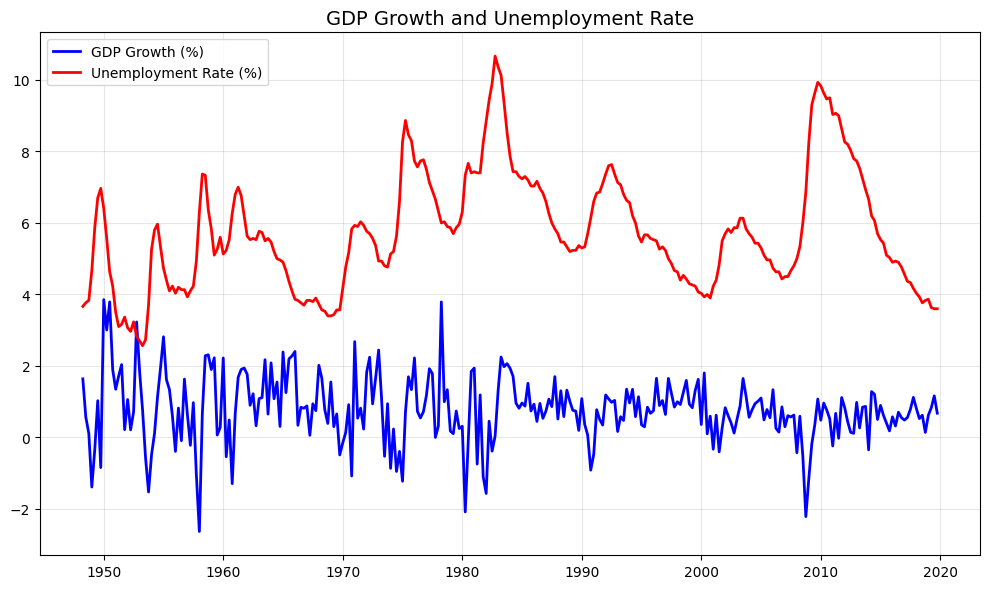


Information Criteria
Lag    AIC      SIC      HQC
 1  -4462.173 -4440.385 -4453.433
 2  -4525.123 -4488.810 -4510.556
 3  -4531.124 -4480.287 -4510.731
 4  -4527.657 -4462.295 -4501.437
 5  -4528.886 -4449.000 -4496.840
 6  -4535.888 -4441.477 -4498.015
 7  -4535.998 -4427.062 -4492.299
 8  -4534.471 -4411.009 -4484.944

Optimal number of lags according to:
AIC :  7
SIC :  2
HQC :  3

Identification matrix S using Blanchard-Quah long-run restriction:
[[ 0.00774523 -0.00283627]
 [-0.00078024  0.00253156]]
Computing 90% confidence bands with 1000 (naive) bootstrap draws...
Bootstrap draw 0/1000
Bootstrap draw 100/1000
Bootstrap draw 200/1000
Bootstrap draw 300/1000
Bootstrap draw 400/1000
Bootstrap draw 500/1000
Bootstrap draw 600/1000
Bootstrap draw 700/1000
Bootstrap draw 800/1000
Bootstrap draw 900/1000


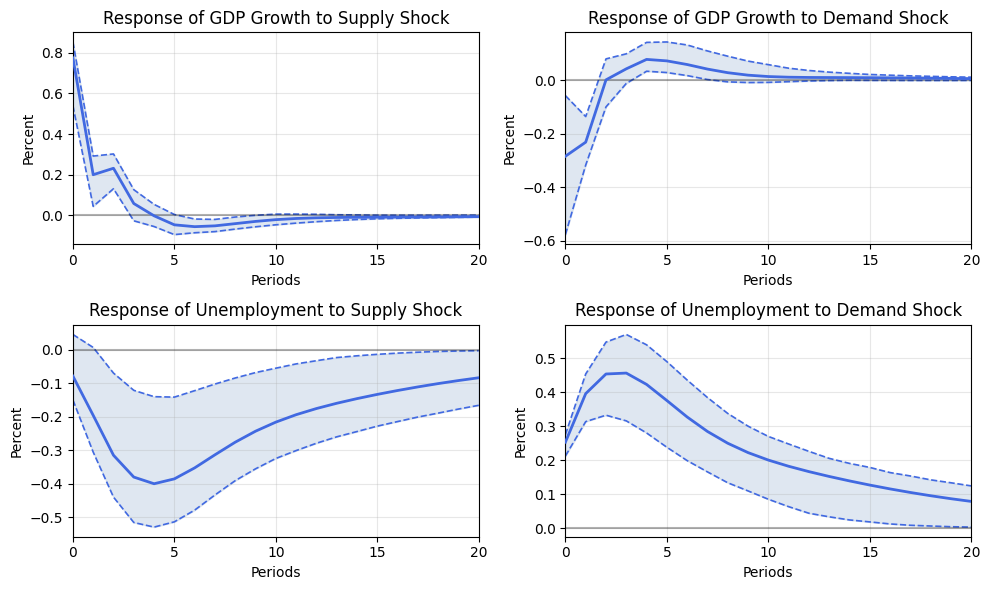

In [ ]:
start_date = '1948-01-01'
end_date='2019-10-01'
#end_date='2017-01-01'

# Download data from fred
df = load_data_from_fred(fred, start_date, end_date)

# Prepare data for estimation
data, nobs, nvars = prepare_data(df)

# Plot the data
plt.figure(figsize=(10, 6))
periods = pd.date_range(start=df.index[1], periods=len(data[0]), freq='QS')
plt.plot(periods, 100 * data[0], 'b-', linewidth=2, label='GDP Growth (%)')
plt.plot(periods, 100 * data[1], 'r-', linewidth=2, label='Unemployment Rate (%)')
plt.title('GDP Growth and Unemployment Rate', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute information criteria to select number of lags for the VAR estimation
criteria = compute_information_criteria(data, maxlags=8)

# Estimate VAR
nlags = criteria['optimal_HQC']
# nlags = 3
var_results = estimate_var(data,nlags)

# BLANCHARD QUAH IDENTIFICATION LONG RUN RESTRICTION
S = BQ_long_run_restrictions(var_results)

print("\nIdentification matrix S using Blanchard-Quah long-run restriction:")
print(S)

# Compute impulse responses
nperiods = 21
irf = compute_impulse_response(var_results, nperiods, S)


# Bootstrap (naive) confidence bands
lbound_naive, ubound_naive, median_naive = bootstrap_confidence_bands(var_results, data, ndraws=1000, nperiods=21, confidence=90)


# Plot IRF and confidence bands using the naive bootstrap
plot_impulse_responses(irf, lbound_naive, ubound_naive)




In [ ]:
# FUNCTIONS TO COMPUTE KILIAN'S BOOTSTRAP-AFTER-BOOTSTRAP CONFIDENCE BANDS

def is_stationary(coef):
    """
    Checks if the companion matrix formed from VAR coefficients is stable
    """
    nvars = coef[0].shape[0]
    nlags = len(coef)

    companion = np.zeros( (nvars * nlags, nvars * nlags) )
    for i in range(nlags):
        companion[:nvars, i * nvars:(i + 1) * nvars] = coef[i]
    companion[nvars:, :-nvars] = np.eye(nvars * (nlags - 1))

    eigenvalues = np.linalg.eigvals(companion)

    return np.all(np.abs(eigenvalues) < 1), np.max(np.abs(eigenvalues))


def compute_bias_corrected_coef( var_results, data, n_bias_draws=100, delta=0.05, max_iter=100 ):
    """
    Estimate bias in VAR coefficients and apply correction preserving stationarity
    """
    nvars = var_results['nvars']
    nlags = var_results['nlags']
    resid = var_results['resid']
    T = resid.shape[1]
    coef_hat = var_results['coef']

    coef_draws = np.zeros( (n_bias_draws, nlags, nvars, nvars) )

    for m in range(n_bias_draws):

        indices = np.random.randint(0, T, T)
        u_star = resid[:, indices]

        y_star = np.zeros((nvars, nlags + T))
        y_star[:, :nlags] = data[:, :nlags]

        for t in range(nlags, nlags + T):
            rhs = var_results['intercept'].copy()
            for lag in range(nlags):
                rhs += coef_hat[lag] @ y_star[:, t - 1 - lag]
            y_star[:, t] = rhs + u_star[:, t - nlags]

        var_star = estimate_var(y_star, nlags)
        coef_draws[m] = np.array(var_star['coef'])

    # Compute bias
    coef_hat_arr = np.array(coef_hat)
    psi = np.mean(coef_draws - coef_hat_arr[None, :, :, :], axis=0)

    # Apply bias correction iteratively to preserve stationarity
    stationary, max_root = is_stationary(coef_hat)
    if not stationary:
        print("VAR is non-stationary; skipping bias correction")
        return coef_hat, psi

    for j in range(max_iter):
        coef_corrected = coef_hat_arr - psi * ((1 - delta) ** j)
        stationary, max_root = is_stationary(coef_corrected)
        if stationary:
            return coef_corrected, psi

    print("Warning: Unable to restore stationarity after bias correction")
    return coef_hat, psi


def bootstrap_confidence_bands_bias_corrected(var_results, data, ndraws=500, nperiods=21, confidence=90, n_bias_draws=100):
    """
    Bootstrap-after-bootstrap with Kilian's bias correction applied to VAR coefficients.
    """
    print(f"Applying Kilian's bias-corrected bootstrap with {ndraws} draws...")

    nvars = var_results['nvars']
    nlags = var_results['nlags']
    resid = var_results['resid']
    T = resid.shape[1]

    # Correct bias in VAR coefficients
    coef_corrected, psi = compute_bias_corrected_coef(var_results, data, n_bias_draws)


    irf_draws = np.zeros((nperiods, nvars, nvars, ndraws))

    for draw in range(ndraws):
        if draw % 100 == 0:
            print(f"Draw {draw}/{ndraws}")

        indices = np.random.randint(0, T, T)
        u_bootstrap = resid[:, indices]

        y_boot = np.zeros((nvars, nlags + T))
        y_boot[:, :nlags] = data[:, :nlags]

        for t in range(nlags, nlags + T):
            rhs = var_results['intercept'].copy()
            for lag in range(nlags):
                rhs += coef_corrected[lag] @ y_boot[:, t - 1 - lag]
            y_boot[:, t] = rhs + u_bootstrap[:, t - nlags]

        var_b = estimate_var(y_boot, nlags)
        S_b = BQ_long_run_restrictions(var_b)
        irf_b = compute_impulse_response(var_b, nperiods, S_b)

        irf_draws[:, :, :, draw] = irf_b

    # Compute percentiles
    alpha = (100 - confidence) / 2
    lower = np.percentile(irf_draws, alpha, axis=3)
    upper = np.percentile(irf_draws, 100 - alpha, axis=3)
    median = np.percentile(irf_draws, 50, axis=3)

    return lower, upper, median


Applying Kilian's bias-corrected bootstrap with 1000 draws...
Draw 0/1000
Draw 100/1000
Draw 200/1000
Draw 300/1000
Draw 400/1000
Draw 500/1000
Draw 600/1000
Draw 700/1000
Draw 800/1000
Draw 900/1000


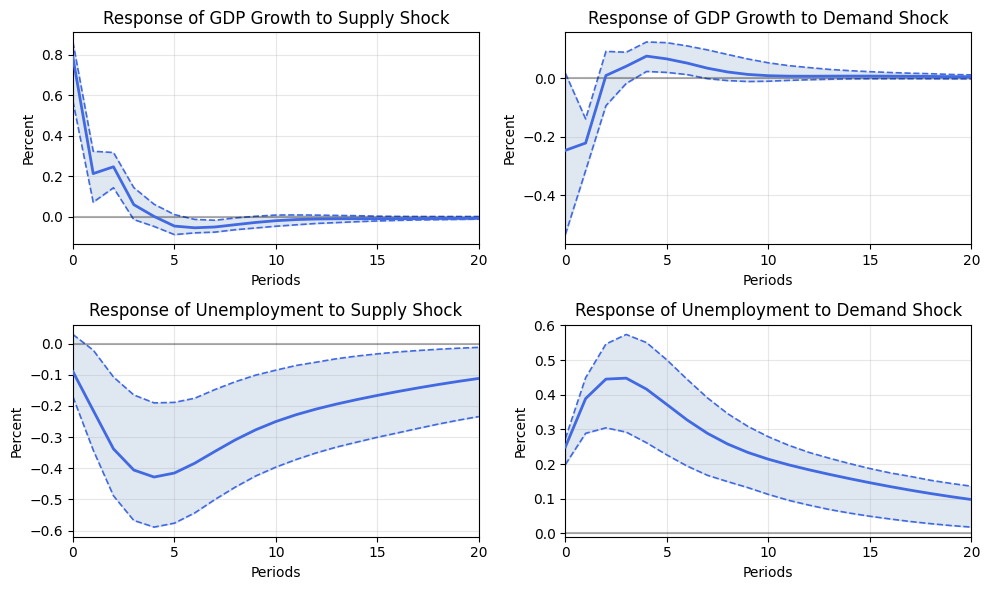

In [ ]:
# COMPUTE BIAS CORRECTED IRF AND BOOTSTRAP-AFTER-BOOTSTRAP CONFIDENCE BANDS

# Correct bias of VAR estimate
coef_corrected, psi = compute_bias_corrected_coef(var_results, data, n_bias_draws=100)
var_result_biascorrect = var_results.copy()
var_result_biascorrect['coef'] = coef_corrected

# Long-run identification using bias-corrected estimates
S_bias_corrected = BQ_long_run_restrictions(var_result_biascorrect)

# Point estimate of IRF (bias corrected)
irf_bias_corrected = compute_impulse_response(var_result_biascorrect, nperiods, S_bias_corrected)

# Bootstrap confidence bands (Kilian)
lbound_kilian, ubound_kilian, median = bootstrap_confidence_bands_bias_corrected(var_results, data, ndraws=1000, nperiods=21, confidence=90, n_bias_draws=100)

plot_impulse_responses(irf_bias_corrected, lbound_kilian, ubound_kilian)

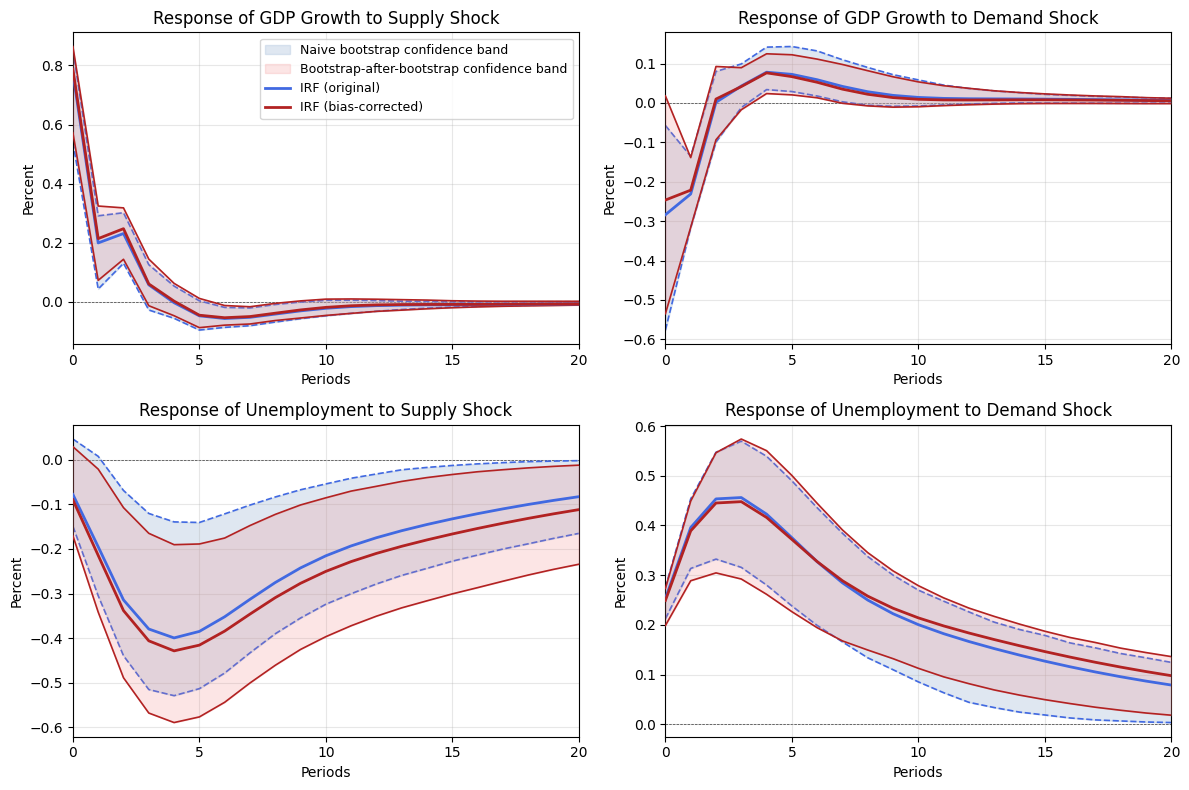

In [ ]:
# Compare naive and boostrap-after-bootstrap confidence bands and point estimate

def plot_impulse_responses_compare_confidence_bands(irf, irf_bias_corrected, lbound_runkle=None, ubound_runkle=None,
                                                    lbound_kilian=None, ubound_kilian=None):
    """
    Compare naive bootstrap and Kilian (bootstrap-after-bootstrap) confidence bands.
    """
    periods = np.arange(irf.shape[0])
    shock_names = ['Supply Shock', 'Demand Shock']
    var_names = ['GDP Growth', 'Unemployment']

    fig, axes = plt.subplots(2, 2, figsize=(12, 8)) # Adjusted figsize for potentially larger labels

    for i, shock_name in enumerate(shock_names):
        for j, var_name in enumerate(var_names):
            ax = axes[j, i]

            # --- Naive confidence bands ---
            if lbound_runkle is not None and ubound_runkle is not None:
                ax.fill_between(periods, 100 * lbound_runkle[:, i, j], 100 * ubound_runkle[:, i, j],
                                color='lightsteelblue', alpha=0.4, label='Naive bootstrap confidence band', zorder=1)
                ax.plot(periods, 100 * lbound_runkle[:, i, j], color='royalblue', linestyle='--', linewidth=1.2, zorder=2)
                ax.plot(periods, 100 * ubound_runkle[:, i, j], color='royalblue', linestyle='--', linewidth=1.2, zorder=2)

            # --- Kilian confidence bands ---
            if lbound_kilian is not None and ubound_kilian is not None:
                ax.fill_between(periods, 100 * lbound_kilian[:, i, j], 100 * ubound_kilian[:, i, j],
                                color='lightcoral', alpha=0.2, label='Bootstrap-after-bootstrap confidence band', zorder=3)
                ax.plot(periods, 100 * lbound_kilian[:, i, j], color='firebrick', linewidth=1.2, zorder=4)
                ax.plot(periods, 100 * ubound_kilian[:, i, j], color='firebrick', linewidth=1.2, zorder=4)

            # --- IRF line (point estimate without bias correction) ---
            ax.plot(periods, 100 * irf[:, i, j], color='royalblue', linewidth=2, label='IRF (original)', zorder=5)

            # --- IRF line (bias corrected) ---
            ax.plot(periods, 100 * irf_bias_corrected[:, i, j], color='firebrick', linewidth=2, label='IRF (bias-corrected)', zorder=5)

            # Axes settings
            ax.set_title(f'Response of {var_name} to {shock_name}')
            ax.set_xlabel('Periods')
            ax.set_ylabel('Percent')
            ax.axhline(0, color='black', linewidth=0.5, linestyle='--', zorder=0)
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, len(periods) - 1)
            ax.set_xticks(np.arange(0, len(periods), 5))

          # Add legend only once
            if i == 0 and j == 0:
              ax.legend(fontsize=9, loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to compare bootstrap confidence bands
plot_impulse_responses_compare_confidence_bands(irf, irf_bias_corrected,
                                                lbound_runkle=lbound_naive,
                                                ubound_runkle=ubound_naive,
                                                lbound_kilian=lbound_kilian,
                                                ubound_kilian=ubound_kilian)
